In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, roc_curve
from scipy.stats import skew, kurtosis
from scipy.fft import fft

from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras import regularizers
import re
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, LSTM, RepeatVector, BatchNormalization
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
from matplotlib import rc
from multiprocessing import cpu_count

In [67]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#93D30C", "#8F00FF", "#01BEFE", "#FFDD00","#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

tf.random.set_seed(42)
TIMESTEPS = 10 # the number of sample to be fed to the NN
FEATURES = 6
LABELS = 3
N_RECORDS = 11
BATCH_SIZE = 128     

In [3]:
df_train = pd.read_csv('dataset/train_motion_data.csv')
df_test = pd.read_csv('dataset/test_motion_data.csv')

### Preprocessing

In [4]:
len(df_train), len(df_test)

(3644, 3084)

In [5]:
# Merge class 'Slow' to 'Normal' class
df_train_2_cl = df_train.copy()
df_test_2_cl = df_test.copy()

two_class_mapping = {'SLOW': 'NORMAL'}
df_train_2_cl['Class'] = df_train_2_cl['Class'].replace(two_class_mapping)
df_test_2_cl['Class'] = df_test_2_cl['Class'].replace(two_class_mapping)

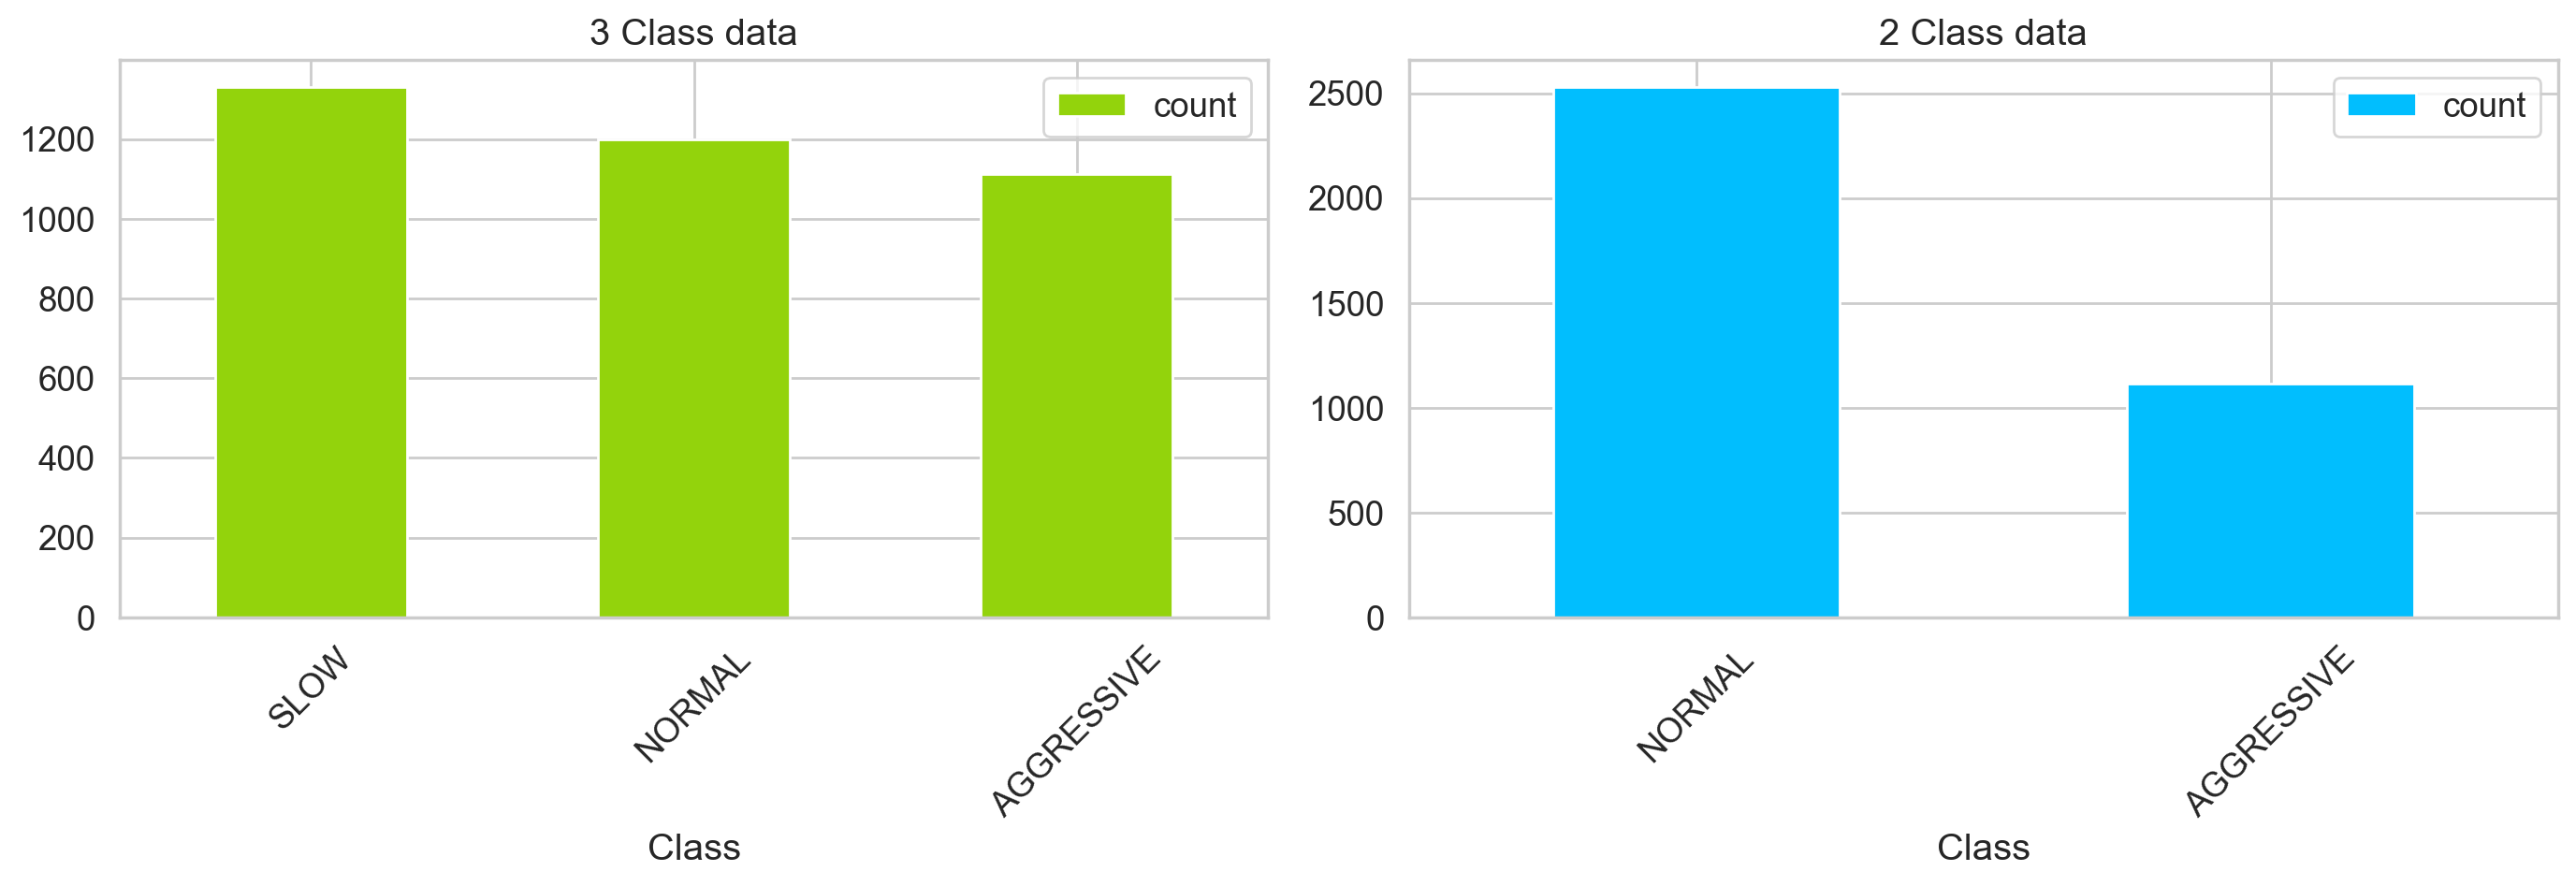

In [6]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df_train.Class.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('3 Class data')
plt.legend()

plt.subplot(1, 2, 2)
df_train_2_cl.Class.value_counts().plot(kind='bar', color="#01BEFE")
plt.xticks(rotation=45)
plt.title('2 Class data')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:

def extract_features(df, window_size):
    features = []
    labels = []
    for i in range(0, len(df), window_size):
        window = df.iloc[i:i+window_size]
        if len(window) == window_size:
            acc_x = window['AccX'].values
            acc_y = window['AccY'].values
            acc_z = window['AccZ'].values
            gyro_x = window['GyroX'].values
            gyro_y = window['GyroY'].values
            gyro_z = window['GyroZ'].values

            # Time domain features
            feature_vector = [
                np.mean(acc_x), np.std(acc_x), skew(acc_x), kurtosis(acc_x),
                np.mean(acc_y), np.std(acc_y), skew(acc_y), kurtosis(acc_y),
                np.mean(acc_z), np.std(acc_z), skew(acc_z), kurtosis(acc_z),
                np.mean(gyro_x), np.std(gyro_x), skew(gyro_x), kurtosis(gyro_x),
                np.mean(gyro_y), np.std(gyro_y), skew(gyro_y), kurtosis(gyro_y),
                np.mean(gyro_z), np.std(gyro_z), skew(gyro_z), kurtosis(gyro_z)
            ]

            # Frequency domain features (FFT)
            fft_acc_x = np.abs(fft(acc_x))
            fft_acc_y = np.abs(fft(acc_y))
            fft_acc_z = np.abs(fft(acc_z))
            fft_gyro_x = np.abs(fft(gyro_x))
            fft_gyro_y = np.abs(fft(gyro_y))
            fft_gyro_z = np.abs(fft(gyro_z))
            feature_vector.extend([
                np.mean(fft_acc_x), np.std(fft_acc_x),
                np.mean(fft_acc_y), np.std(fft_acc_y),
                np.mean(fft_acc_z), np.std(fft_acc_z),
                np.mean(fft_gyro_x), np.std(fft_gyro_x),
                np.mean(fft_gyro_y), np.std(fft_gyro_y),
                np.mean(fft_gyro_z), np.std(fft_gyro_z)
            ])
            
            features.append(feature_vector)
            labels.append(window['Class'].mode()[0])  # Assuming class labels are consistent within a window

    return np.array(features), np.array(labels)

#### Noise removing

In [8]:
df_train_normal = df_train.loc[df_train['Class'] == "NORMAL"]
df_train_slow = df_train.loc[df_train['Class'] == "SLOW"]
df_train_aggressive = df_train.loc[df_train['Class'] == "AGGRESSIVE"]

df_test_normal = df_test.loc[df_test['Class'] == "NORMAL"]
df_test_slow = df_train.loc[df_train['Class'] == "SLOW"]
df_test_aggressive = df_test.loc[df_test['Class'] == "AGGRESSIVE"]

In [9]:
df_train_normal = df_train_normal.iloc[N_RECORDS:]
df_train_normal = df_train_normal.iloc[:-N_RECORDS]

df_train_aggressive = df_train_aggressive.iloc[N_RECORDS:]
df_train_aggressive = df_train_aggressive.iloc[:-N_RECORDS]

df_train_slow = df_train_slow.iloc[N_RECORDS:]
df_train_slow = df_train_slow.iloc[:-N_RECORDS]

df_test_normal = df_test_normal.iloc[N_RECORDS:]
df_test_normal = df_test_normal.iloc[:-N_RECORDS]

df_test_aggressive = df_test_aggressive.iloc[N_RECORDS:]
df_test_aggressive = df_test_aggressive.iloc[:-N_RECORDS]

df_test_slow = df_test_slow.iloc[N_RECORDS:]
df_test_slow = df_test_slow.iloc[:-N_RECORDS]

df_train_slow = df_train_slow.tail(1260)
df_train_normal = df_train_normal.tail(1130)
df_train_aggressive = df_train_aggressive.tail(1040)

df_test_slow = df_test_slow.tail(1185)
df_test_normal = df_test_normal.tail(905)
df_test_aggressive = df_test_aggressive.tail(720)

In [10]:
# Features
X_train_normal = df_train_normal.iloc[: , :FEATURES]
X_train_slow = df_train_slow.iloc[: , :FEATURES]
X_train_aggressive = df_train_aggressive.iloc[: , :FEATURES]

X_test_normal = df_test_normal.iloc[: , :FEATURES]
X_test_slow = df_test_slow.iloc[: , :FEATURES]
X_test_aggressive = df_test_aggressive.iloc[: , :FEATURES]

# Labels
y_train_normal = df_train_normal.Class
y_train_slow = df_train_slow.Class
y_train_aggressive = df_train_aggressive.Class

y_test_normal = df_test_normal.Class
y_test_slow = df_test_slow.Class
y_test_aggressive = df_test_aggressive.Class


In [54]:
X_train = pd.concat([X_train_slow, X_train_normal, X_train_aggressive])
y_train = pd.concat([y_train_slow, y_train_normal, y_train_aggressive])

X_test = pd.concat([X_test_slow, X_test_normal, X_test_aggressive])
y_test = pd.concat([y_test_slow, y_test_normal, y_test_aggressive])

X_train.shape, y_train.shape

((3430, 6), (3430,))

In [55]:
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

In [56]:
y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)

In [57]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [58]:
train_samples = X_train.shape[0] // TIMESTEPS
X_train = X_train.reshape(train_samples, TIMESTEPS, FEATURES)

test_samples = X_test.shape[0] // TIMESTEPS
X_test = X_test.reshape(test_samples, TIMESTEPS, FEATURES)

print('Train features shape: ' + str(X_train.shape[0]))
print('Test features shape: ' + str(X_test.shape[0]))

Train features shape: 343
Test features shape: 281


In [59]:
y_train = y_train[::TIMESTEPS]
y_test = y_test[::TIMESTEPS]

print('Train labels shape: ' + str(y_train.shape[0]))
print('Test labels shape: ' + str(y_test.shape[0]))

Train labels shape: 343
Test labels shape: 281


### 2 Class Labelling

In [17]:
df_train_2_normal = df_train_2_cl.loc[df_train_2_cl['Class'] == "NORMAL"]
df_train_2_aggressive = df_train_2_cl.loc[df_train_2_cl['Class'] == "AGGRESSIVE"]

df_test_2_normal = df_test_2_cl.loc[df_test_2_cl['Class'] == "NORMAL"]
df_test_2_aggressive = df_test_2_cl.loc[df_test_2_cl['Class'] == "AGGRESSIVE"]

In [18]:
df_train_2_normal = df_train_2_normal.iloc[N_RECORDS:]
df_train_2_normal = df_train_2_normal.iloc[:-N_RECORDS]

df_train_2_aggressive = df_train_2_aggressive.iloc[N_RECORDS:]
df_train_2_aggressive = df_train_2_aggressive.iloc[:-N_RECORDS]

df_test_2_normal = df_test_2_normal.iloc[N_RECORDS:]
df_test_2_normal = df_test_2_normal.iloc[:-N_RECORDS]

df_test_2_aggressive = df_test_2_aggressive.iloc[N_RECORDS:]
df_test_2_aggressive = df_test_2_aggressive.iloc[:-N_RECORDS]

df_train_2_normal = df_train_2_normal.tail(2500)
df_train_2_aggressive = df_train_2_aggressive.tail(1090)

df_test_2_normal = df_test_2_normal.tail(2240)
df_test_2_aggressive = df_test_2_aggressive.tail(790)

df_train_2_normal.shape, df_train_2_aggressive.shape, df_test_2_normal.shape, df_test_2_aggressive.shape

((2500, 8), (1090, 8), (2240, 8), (790, 8))

In [19]:
# Features
X_train_2_normal = df_train_2_normal.iloc[: , :FEATURES]
X_train_2_aggressive = df_train_2_aggressive.iloc[: , :FEATURES]

X_test_2_normal = df_test_2_normal.iloc[: , :FEATURES]
X_test_2_aggressive = df_test_2_aggressive.iloc[: , :FEATURES]

# Labels
y_train_2_normal = df_train_2_normal.Class
y_train_2_aggressive = df_train_2_aggressive.Class

y_test_2_normal = df_test_2_normal.Class
y_test_2_aggressive = df_test_2_aggressive.Class

In [20]:
X_train_2 = pd.concat([X_train_2_normal, X_train_2_aggressive])
y_train_2 = pd.concat([y_train_2_normal, y_train_2_aggressive])

X_test_2 = pd.concat([X_test_2_normal, X_test_2_aggressive])
y_test_2 = pd.concat([y_test_2_normal, y_test_2_aggressive])

X_train_2.shape, y_train_2.shape

((3590, 6), (3590,))

In [21]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.fit_transform(X_test_2)

In [22]:
labelEncoder_2 = LabelEncoder()
y_train_2 = labelEncoder_2.fit_transform(y_train_2)
y_test_2 = labelEncoder_2.transform(y_test_2)

y_train_2 = to_categorical(y_train_2, num_classes=LABELS)
y_test_2 = to_categorical(y_test_2, num_classes=LABELS)

In [23]:
train_samples_two = X_train_2.shape[0] // TIMESTEPS
X_train_two = X_train_2.reshape(train_samples_two, TIMESTEPS, FEATURES)

test_samples_two = X_test_2.shape[0] // TIMESTEPS
X_test_two = X_test_2.reshape(test_samples_two, TIMESTEPS, FEATURES)

print('Train features shape: ' + str(X_train_two.shape[0]))
print('Test features shape: ' + str(X_test_two.shape[0]))

Train features shape: 359
Test features shape: 303


In [24]:
y_train_two = y_train_2[::TIMESTEPS]
y_test_two = y_test_2[::TIMESTEPS]

print('Train labels shape: ' + str(y_train_two.shape[0]))
print('Test labels shape: ' + str(y_test_two.shape[0]))

Train labels shape: 359
Test labels shape: 303


#### LSTM Model Building

In [25]:
def model_builder(hp):
    model = tf.keras.Sequential()

    # First LSTM layer with input shape and batch normalization
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=512, step=32), 
                   input_shape=(TIMESTEPS, FEATURES), return_sequences=True))
    model.add(BatchNormalization())

    # Additional LSTM layers with dropout and batch normalization
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(
            hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32),
            dropout=hp.Float(f'dropout_{i}_rate', min_value=0, max_value=0.5, step=0.1),
            return_sequences=True
        ))
        model.add(BatchNormalization())

    # Final LSTM layer without return_sequences
    model.add(LSTM(hp.Int('lstm_output_neurons', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(BatchNormalization())

    # Dropout for regularization
    model.add(Dropout(hp.Float('output_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    # Dense layer
    model.add(Dense(hp.Int('dense_neurons', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())

    # Output layer with softmax activation
    model.add(Dense(LABELS, activation='softmax'))

    # Learning rate selection
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    # Model compilation with additional metrics
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

#### Training model for 3 class

In [26]:
tuner_3 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='lstm_dir_3',
                     project_name='driving_behavior')

Reloading Tuner from lstm_dir_3/driving_behavior/tuner0.json


#### Training model for 2 class

In [27]:
tuner_2 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='lstm_dir_2',
                     project_name='driving_behavior')

Reloading Tuner from lstm_dir_2/driving_behavior/tuner0.json


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [29]:
tuner_3.search(
        x=X_train,
        y=y_train,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[stop_early], 
        shuffle=True
)

In [30]:
tuner_2.search(
        x=X_train_two,
        y=y_train_two,
        epochs=50,
        validation_data=(X_test_two, y_test_two),
        callbacks=[stop_early], 
        shuffle=True
)

In [31]:
best_hyperparameters = tuner_2.get_best_hyperparameters()[0]
best_hyperparameters.values

{'input_unit': 32,
 'n_layers': 1,
 'lstm_0_units': 128,
 'dropout_0_rate': 0.4,
 'lstm_output_neurons': 160,
 'output_dropout_rate': 0.2,
 'dense_neurons': 320,
 'learning_rate': 0.01,
 'lstm_1_units': 256,
 'dropout_1_rate': 0.4,
 'lstm_2_units': 160,
 'dropout_2_rate': 0.4,
 'lstm_3_units': 256,
 'dropout_3_rate': 0.4,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0058'}

In [32]:
best_hps_3 = tuner_3.get_best_hyperparameters(num_trials=1)[0]
best_hps_2 = tuner_2.get_best_hyperparameters(num_trials=1)[0]

In [33]:
# Build the model with the optimal hyperparameters and train it on the data for 60 epochs
model_1 = tuner_3.hypermodel.build(best_hps_3)
history_3 = model_1.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), 
    callbacks=[stop_early], shuffle=True)

model_2 = tuner_2.hypermodel.build(best_hps_2)
history_2 = model_2.fit(X_train_two, y_train_two, epochs=50, validation_data=(X_test_two, y_test_two), 
    callbacks=[stop_early], 
    shuffle=True)

val_acc_per_epoch_1 = history_3.history['val_accuracy']
best_epoch_1 = val_acc_per_epoch_1.index(max(val_acc_per_epoch_1)) + 1

val_acc_per_epoch_2 = history_2.history['val_accuracy']
best_epoch_2= val_acc_per_epoch_2.index(max(val_acc_per_epoch_2)) + 1
print(f'Best epoch for 3 class data: {best_epoch_1} \n Best epoch for 2 class data: {best_epoch_2}')

/Users/asus/Desktop/Comp702_Dissertation/driving_detection/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.2884 - loss: 1.5954 - precision: 0.2911 - recall: 0.2331 - val_accuracy: 0.4270 - val_loss: 1.0933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.4880 - loss: 1.1960 - precision: 0.5038 - recall: 0.3729 - val_accuracy: 0.4199 - val_loss: 1.0861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5041 - loss: 1.0144 - precision: 0.5787 - recall: 0.3791 - val_accuracy: 0.4235 - val_loss: 1.0788 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5445 - loss: 0.9461 - precision: 0.6149 - recall: 0.4313 - val_accuracy: 0.4270 - val_loss: 1.0766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5658 - loss: 0.8718 - precision: 0.6609 - recall: 0.4469 - val_a

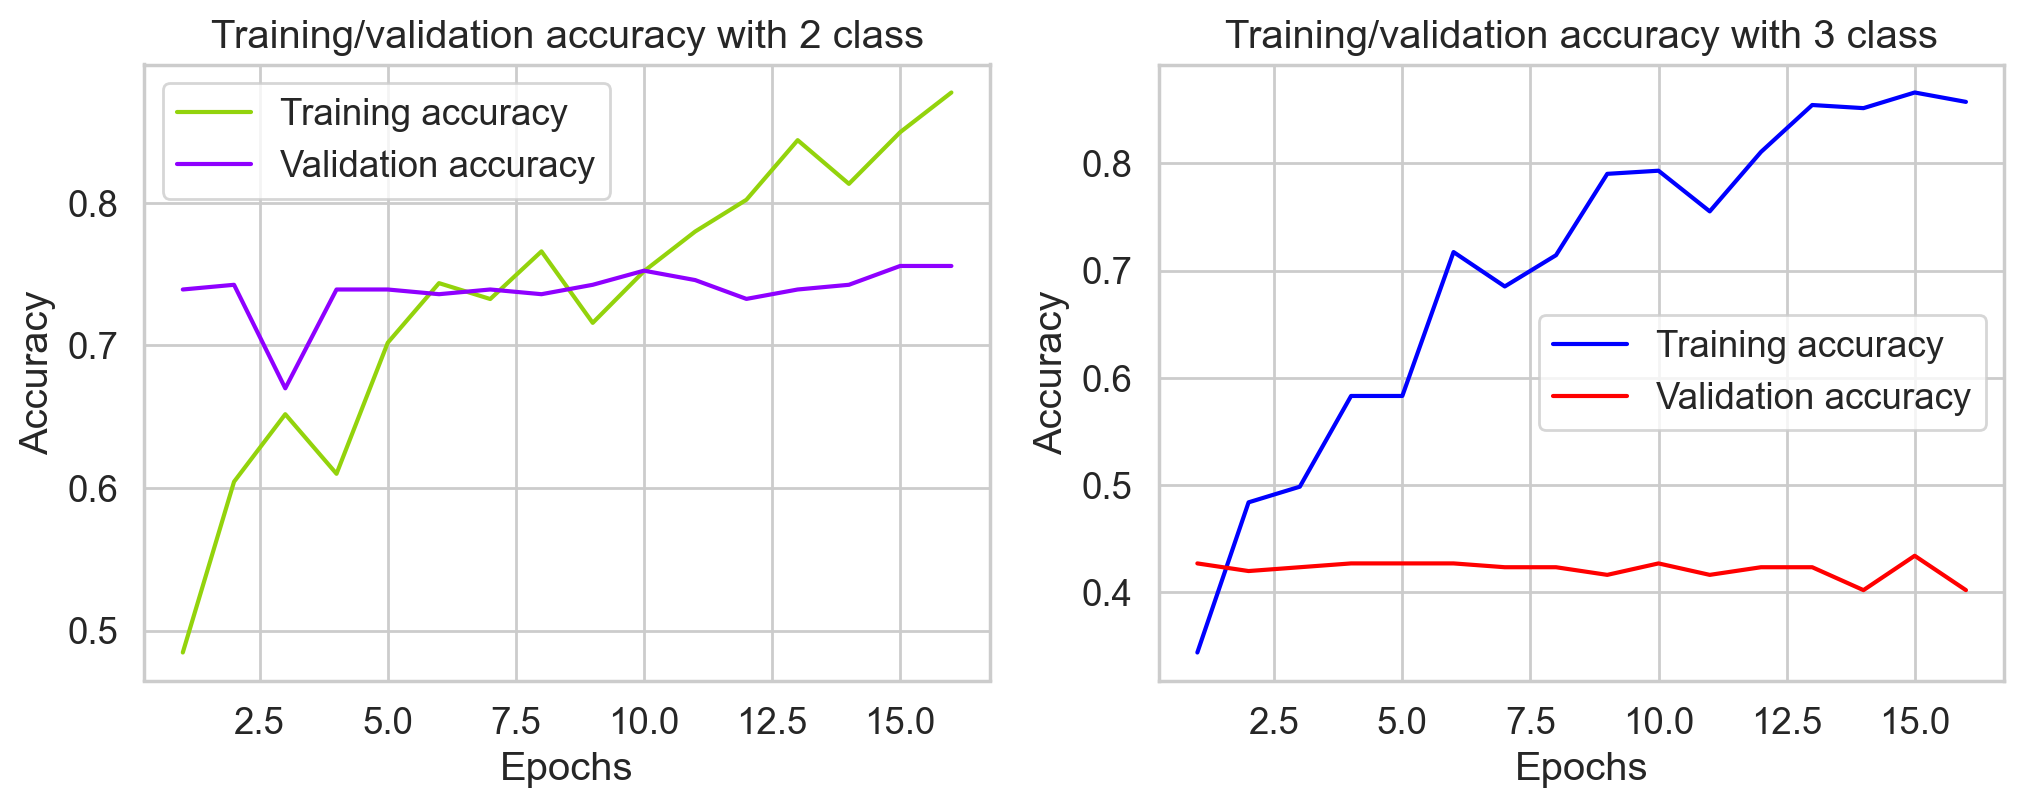

In [34]:
# Extract the accuracy values from the history
training_accuracy = history_2.history['accuracy']
validation_accuracy = history_2.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

training_accuracy_2 = history_3.history['accuracy']
validation_accuracy_2 = history_3.history['val_accuracy']
epochs_2 = range(1, len(training_accuracy_2) + 1)

# Plot the accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, validation_accuracy, label='Validation accuracy')
plt.title('Training/validation accuracy with 2 class')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_2, training_accuracy_2, label='Training accuracy', color="blue")
plt.plot(epochs_2, validation_accuracy_2, label='Validation accuracy', color="red")
plt.title('Training/validation accuracy with 3 class')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Training with defined the best hyperparameters (example: epoch)

In [35]:
hypermodel_1 = tuner_3.hypermodel.build(best_hps_3)
hypermodel_2 = tuner_2.hypermodel.build(best_hps_2)

# Retrain the model
hh_1 = hypermodel_1.fit(X_train, y_train, epochs=best_epoch_1, validation_data=(X_test, y_test), 
    callbacks=[stop_early])
hh_2 = hypermodel_2.fit(X_train_two, y_train_two, epochs=best_epoch_2, validation_data=(X_test_two, y_test_two), 
    callbacks=[stop_early])

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.3569 - loss: 1.4847 - precision: 0.3501 - recall: 0.2877 - val_accuracy: 0.4235 - val_loss: 1.0910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3803 - loss: 1.2697 - precision: 0.4158 - recall: 0.2877 - val_accuracy: 0.4235 - val_loss: 1.0895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.4770 - loss: 1.0256 - precision: 0.5369 - recall: 0.3307 - val_accuracy: 0.4235 - val_loss: 1.0878 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5606 - loss: 0.9018 - precision: 0.6029 - recall: 0.4043 - val_accuracy: 0.4377 - val_loss: 1.0838 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6056 - loss: 0.8614 - precision: 0.6355 - recall: 0.4664 - val_a

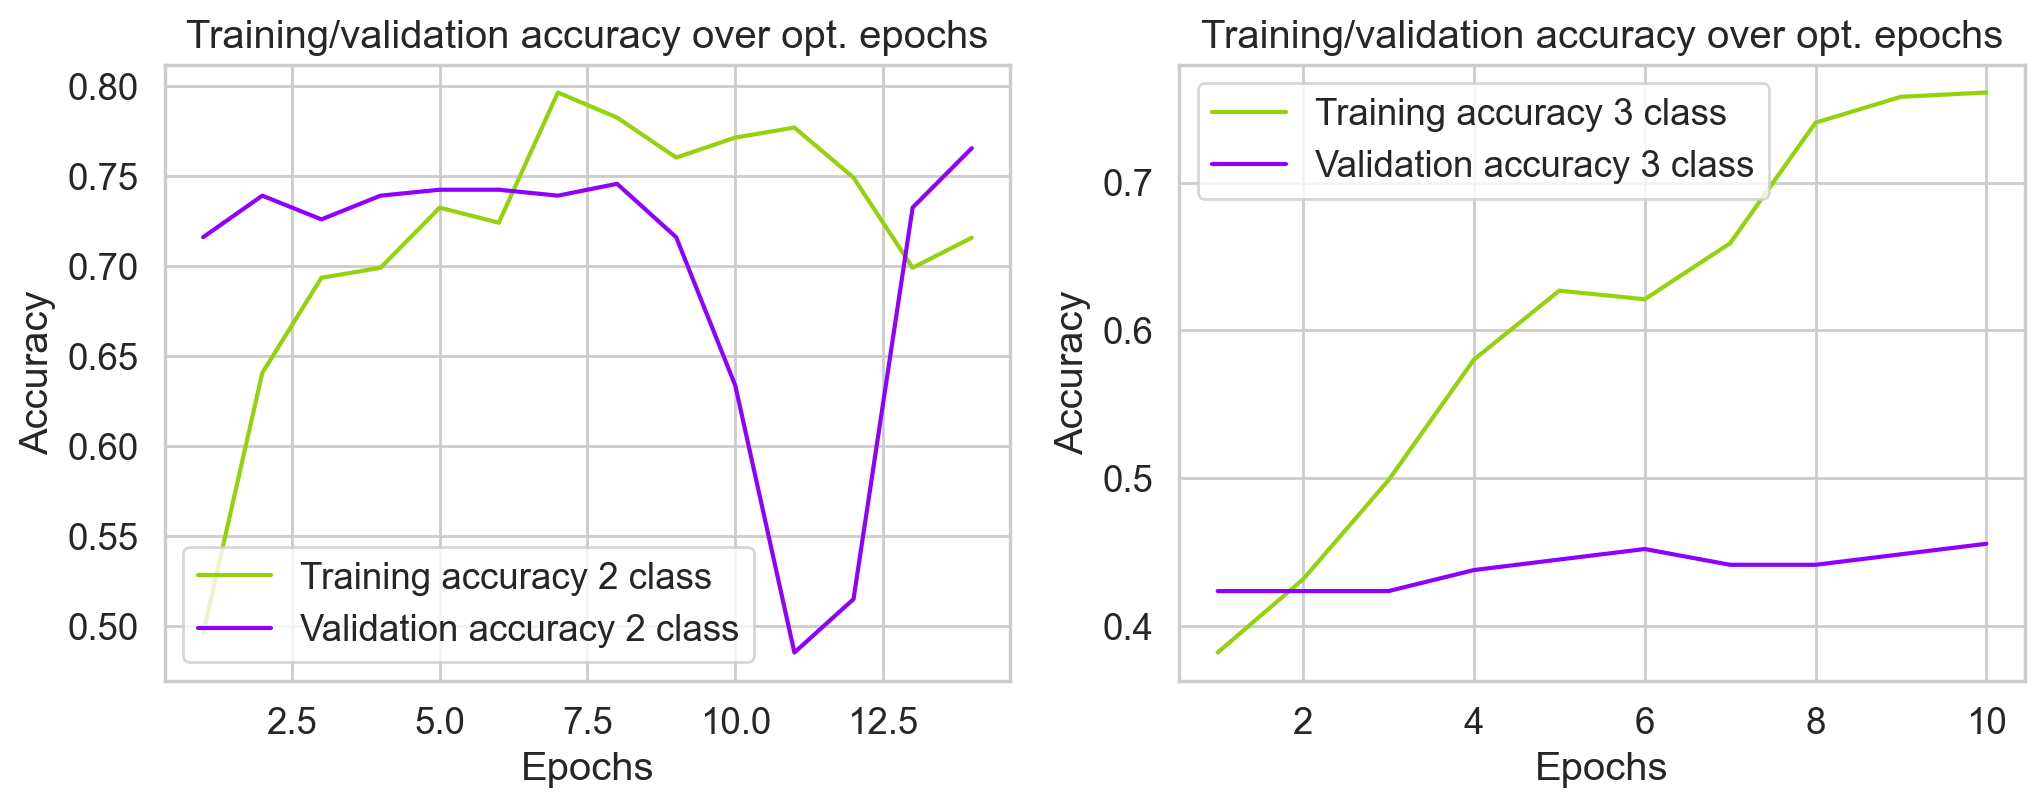

In [36]:
# Extract the accuracy values from the history
training_accuracy_t = hh_1.history['accuracy']
validation_accuracy_t = hh_1.history['val_accuracy']
epochs_t = range(1, len(training_accuracy_t) + 1)

training_accuracy_s = hh_2.history['accuracy']
validation_accuracy_s = hh_2.history['val_accuracy']
epochs_s = range(1, len(training_accuracy_s) + 1)

# Plot the accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_s, training_accuracy_s, label='Training accuracy 2 class')
plt.plot(epochs_s, validation_accuracy_s, label='Validation accuracy 2 class')
plt.title('Training/validation accuracy over opt. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_t, training_accuracy_t, label='Training accuracy 3 class')
plt.plot(epochs_t, validation_accuracy_t, label='Validation accuracy 3 class')
plt.title('Training/validation accuracy over opt. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
eval_result = hypermodel_1.evaluate(X_test, y_test)
eval_result_2 = hypermodel_2.evaluate(X_test_two, y_test_two)

print(f"Test loss, Test accuracy (3 class): {eval_result} \n Test loss, Test accuracy (2 class): {eval_result_2}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6927 - loss: 0.8849 - precision: 0.7165 - recall: 0.3707
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8899 - loss: 0.3510 - precision: 0.8899 - recall: 0.8899 
Test loss, Test accuracy (3 class): [1.0785905122756958, 0.4555160105228424, 0.46715328097343445, 0.2277580052614212] 
 Test loss, Test accuracy (2 class): [0.7573769092559814, 0.7656765580177307, 0.7656765580177307, 0.7656765580177307]


In [38]:
best_model_1 = tuner_3.get_best_models()[0]
best_model_2 = tuner_2.get_best_models()[0]

/Users/asus/Desktop/Comp702_Dissertation/driving_detection/.venv/lib/python3.12/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/Users/asus/Desktop/Comp702_Dissertation/driving_detection/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/asus/Desktop/Comp702_Dissertation/driving_detection/.venv/lib/python3.12/site-

In [39]:
y_pred = best_model_1.predict(x=X_test)
y_pred_2_cl = best_model_2.predict(x=X_test_two)

df_predicted = pd.DataFrame(y_pred, columns=['Aggressive', 'Normal', 'Slow'])

df_predicted

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,Aggressive,Normal,Slow
0,0.008213,0.798653,0.193135
1,0.061956,0.074713,0.863331
2,0.020450,0.062971,0.916579
3,0.085478,0.214890,0.699632
4,0.015257,0.626568,0.358175
...,...,...,...
276,0.115997,0.332070,0.551933
277,0.018269,0.185124,0.796607
278,0.022254,0.076502,0.901244
279,0.015726,0.775170,0.209104


In [40]:
class_labels = np.argmax(y_train, axis=1)

# Fit the LabelEncoder with the class labels
labelEncoder.fit(class_labels)

actual_y_test = np.argmax(y_test, axis=1)
actual = labelEncoder.inverse_transform(actual_y_test)

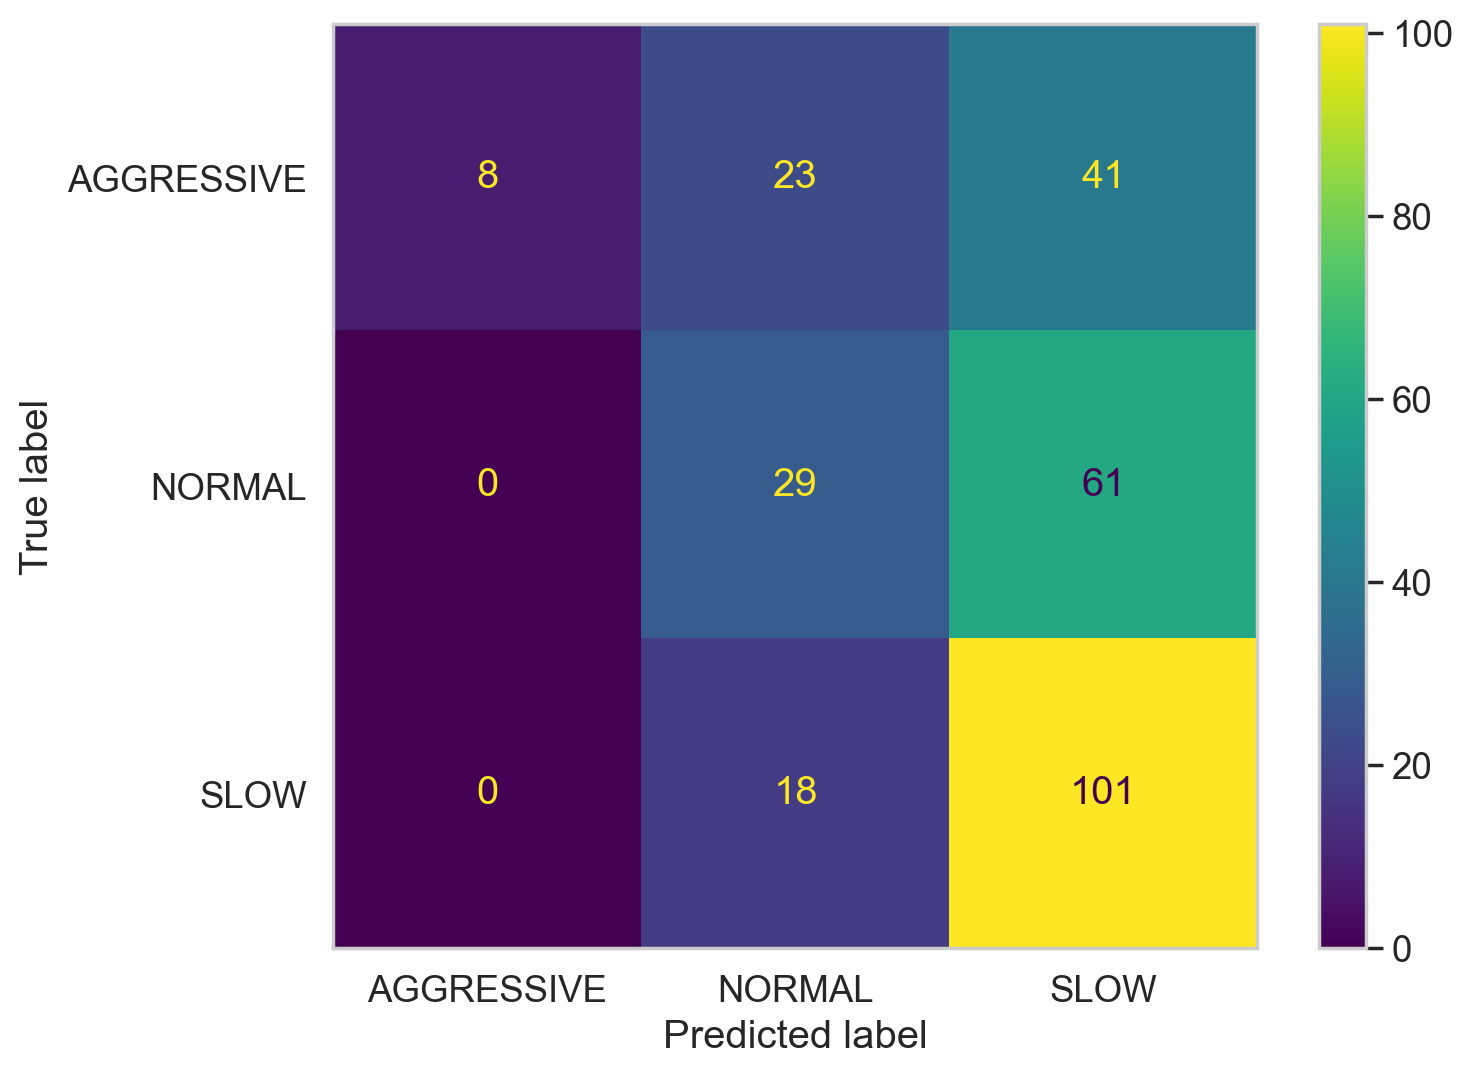

In [41]:
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(actual_y_test, y_pred)
classes = ['AGGRESSIVE', 'NORMAL', 'SLOW']
disp = ConfusionMatrixDisplay.from_predictions(actual_y_test, y_pred, display_labels=classes)

plt.rcParams['figure.figsize'] = [12, 6]
plt.grid(False)
plt.show()

## Multi Class classification with Deep Learning 

In [62]:
# Changing labels
class_mapping = {'SLOW':0, 'NORMAL': 1, 'AGGRESSIVE': 2}
df_train['Class'] = df_train['Class'].replace(class_mapping)
df_test['Class'] = df_test['Class'].replace(class_mapping)

features_mlp = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']

X_train_mlp = df_train[features_mlp]
X_test_mlp = df_test[features_mlp]

y_train_mlp = df_train['Class']
y_test_mlp = df_test['Class']

y_test_mlp

0       2
1       2
2       2
3       2
4       2
       ..
3079    0
3080    0
3081    0
3082    0
3083    0
Name: Class, Length: 3084, dtype: int64

In [63]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_test_mlp = scaler.fit_transform(X_test_mlp)

In [64]:
y_train_mlp_encoded = to_categorical(y_train_mlp)
y_test_mlp_encoded = to_categorical(y_test_mlp)
y_train_mlp_encoded.shape

(3644, 3)

In [68]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=FEATURES))
model.add(Dense(32, activation='relu', activity_regularizer=regularizers.L2(0.0001)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train_mlp_encoded.shape[1], activation='softmax'))

model.compile(loss=binary_crossentropy, optimizer=Adam(), metrics=['accuracy'])

history = model.fit(X_train_mlp, y_train_mlp_encoded,
          batch_size=BATCH_SIZE,
          epochs=200,
          verbose=1,
          validation_data=(X_test_mlp, y_test_mlp_encoded), 
          callbacks=[stop_early])

loss, accuracy = model.evaluate(X_test_mlp, y_test_mlp_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3652 - loss: 0.6882 - val_accuracy: 0.4128 - val_loss: 0.6600
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3610 - loss: 0.6623 - val_accuracy: 0.4137 - val_loss: 0.6448
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3632 - loss: 0.6481 - val_accuracy: 0.4235 - val_loss: 0.6354
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3904 - loss: 0.6376 - val_accuracy: 0.4491 - val_loss: 0.6283
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.4175 - loss: 0.6301 - val_accuracy: 0.4578 - val_loss: 0.6234
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.4274 - loss: 0.6242 - val_accuracy: 0.4553 - val_loss: 0.6205
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4304 - loss: 0.6188 - val_accuracy: 0.4436 - val_loss: 0.6195
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.4376 - loss: 0.6147 - val_accuracy: 0.44

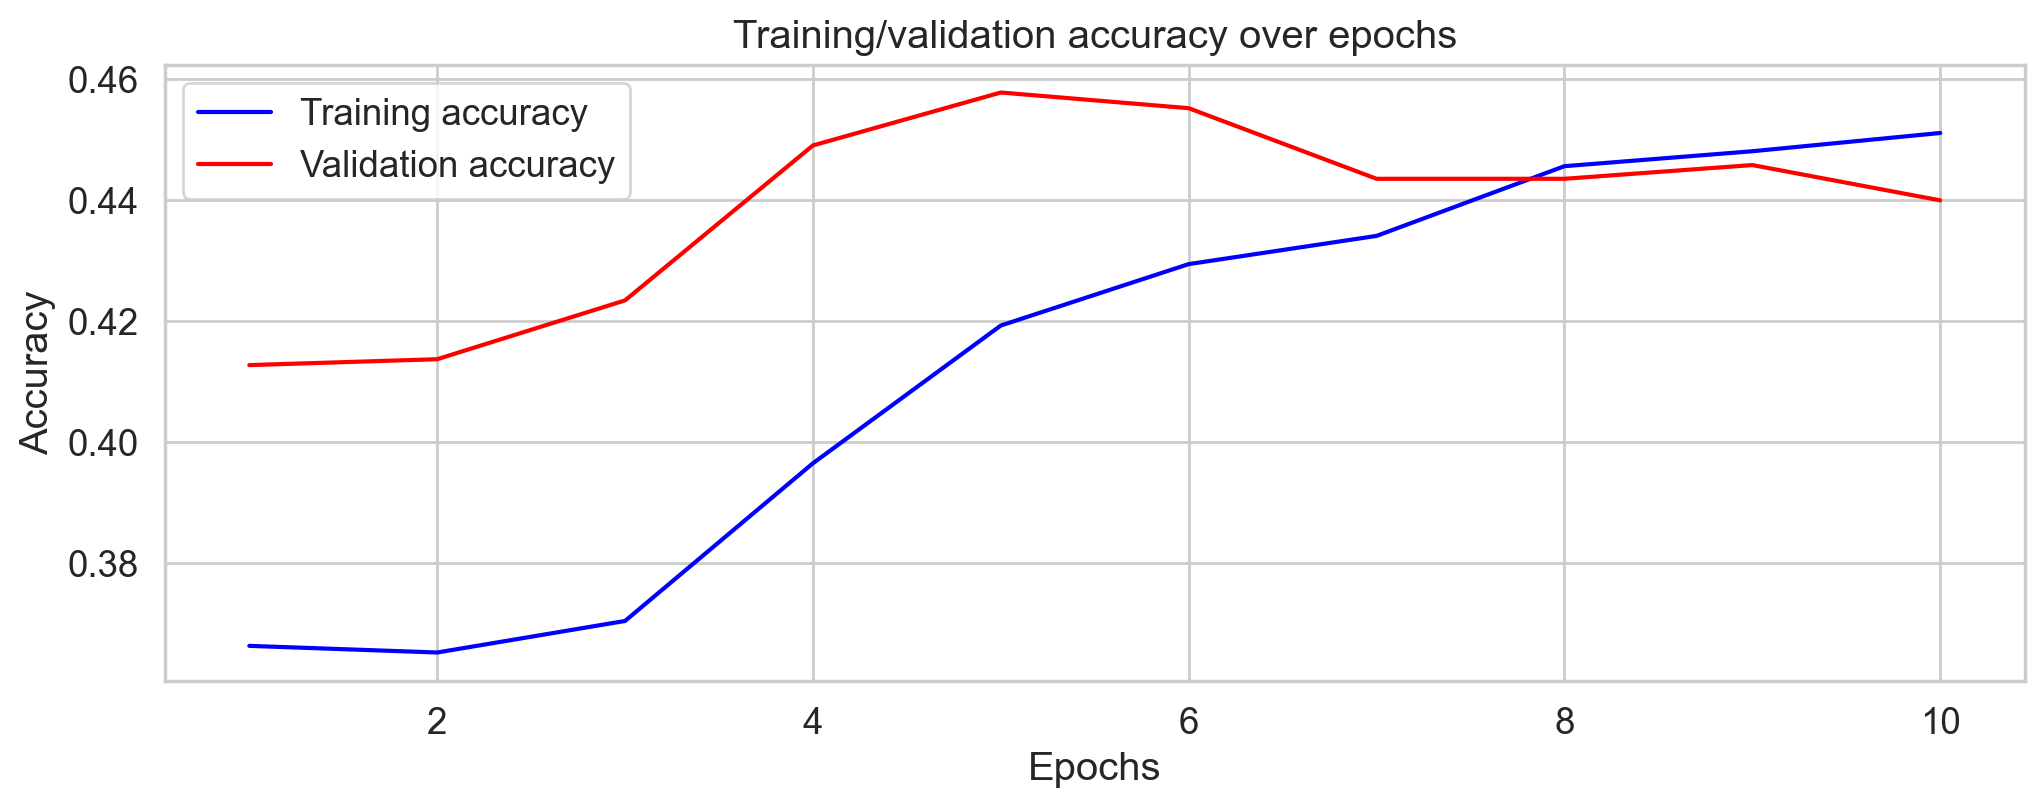

In [69]:
training_accuracy_nn = history.history['accuracy']
validation_accuracy_nn = history.history['val_accuracy']
epochs_nn = range(1, len(training_accuracy_nn) + 1)

# Plot the accuracy values
plt.figure(figsize=(12, 4))

plt.plot(epochs_nn, training_accuracy_nn, color='blue', label='Training accuracy')
plt.plot(epochs_nn, validation_accuracy_nn, color='red', label='Validation accuracy')
plt.title('Training/validation accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Random forest classification

In [ ]:
# Joining train and test together to get one, bad it was bad idea. Accuracy was only 38-42%

file_names = []
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

merged_data = pd.DataFrame()

for filename in reversed(file_names):
    df = pd.read_csv(filename, encoding='utf-8')
    merged_data = pd.concat([merged_data, df], ignore_index=True)

merged_data.to_csv('dataset/merged_data_pandas.csv', index=False)

In [ ]:
df_merged = pd.read_csv('dataset/merged_data_pandas.csv')
df_merged = df_merged.drop(["Unnamed: 0"], axis=1)
df_merged = df_merged.sample(frac=1)
df_merged

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
3846,0.450294,-1.935626,-0.299852,0.013439,0.019166,-0.061239,AGGRESSIVE,819031.0
3988,-0.070973,-0.441820,-1.704836,-0.048869,-0.035201,-0.039859,AGGRESSIVE,819108.0
5841,0.365787,0.555583,0.568105,0.052534,0.242132,-0.117439,SLOW,820230.0
5148,1.644635,-0.645160,0.568571,-0.033598,0.027718,-0.114995,NORMAL,819813.0
2651,-1.419939,-1.878079,-0.421780,0.056352,-0.020159,0.016417,SLOW,3583227.0
...,...,...,...,...,...,...,...,...
5075,-2.209384,-0.798986,0.835418,0.082467,-0.004658,0.216704,NORMAL,819773.0
6116,0.711656,1.637258,1.197786,-0.011606,0.038103,0.021838,SLOW,820379.0
3735,-1.331335,-0.287054,0.380271,0.070860,-0.041310,0.175166,AGGRESSIVE,818971.0
482,0.559877,1.053282,-0.293661,-0.004123,-0.072082,0.055512,NORMAL,3581889.0


In [87]:
# Changing labels
class_mapping = {'NORMAL': 1, 'AGGRESSIVE': 2}
df_train['Class'] = df_train['Class'].replace(class_mapping)
df_test['Class'] = df_test['Class'].replace(class_mapping)

In [88]:
df_train_2_cl = df_train_2_cl.dropna()

In [89]:
df_test_2_cl = df_test_2_cl.dropna()

In [90]:
window_size = 8

# Extract features and labels
X_train_rf, y_train_rf = extract_features(df_train_2_cl, window_size)
X_test_rf, y_test_rf = extract_features(df_test_2_cl, window_size)


In [91]:
# Splitting to training and testing
X_train_rf.shape, X_test_rf.shape

((455, 36), (385, 36))

In [92]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.fit_transform(X_test_rf)

In [95]:
rfc = RandomForestClassifier(n_estimators=300, random_state=42)

rf_history = rfc.fit(X_train_rf, y_train_rf)

y_pred_rf = rfc.predict(X_test_rf)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_rf, y_pred_rf)))

Model accuracy score: 0.7948


## KNN with sklearn

In [97]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_rf, y_train_rf, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

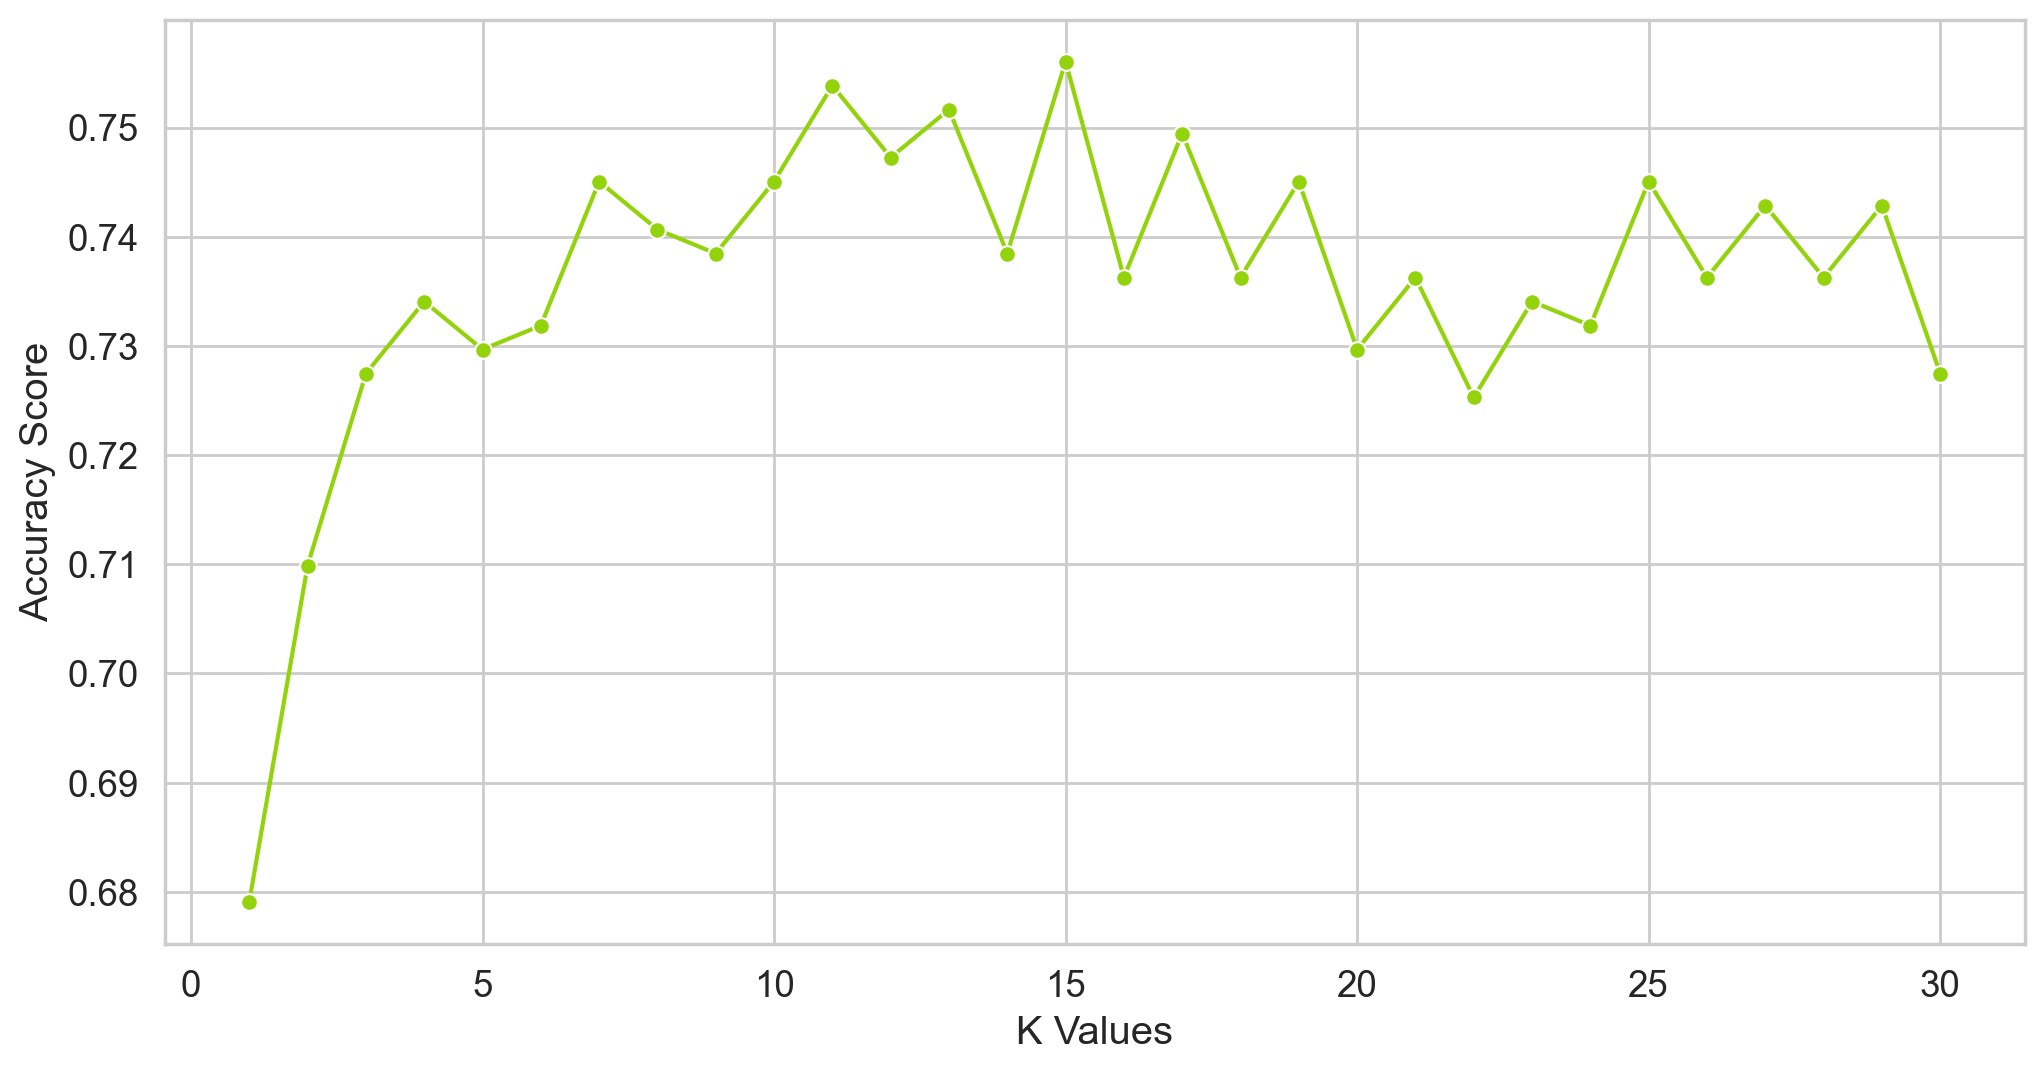

In [98]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

## Pytorch deep learning